## 데이터 추출하는 함수 선언
* datasets/housing 디렉터리를 현제 작업공간에 만든다.
* housing.tgz파일을 내려받고 같은 디렉터리에 압축을 풀어 housing.csv파일을 만든다.
----

In [66]:
import os
import tarfile
import urllib
import urllib.request

DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH=os.path.join("datasets","housing")
HOUSING_URL=DOWNLOAD_ROOT+"datasets/housing/housing.tgz"
def fetch_housing_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
  os.makedirs(housing_path,exist_ok=True)
  tgz_path=os.path.join(housing_path,"housing.tgz")
  urllib.request.urlretrieve(housing_url,tgz_path)
  housing_tgz=tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

## 판다스로 데이터 읽어들이는 함수
* 모든 데이터를 담은 판다스의 데이터프레임 객체를 반환한다.
---

In [67]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
  csv_path=os.path.join(housing_path,"housing.csv")
  return pd.read_csv(csv_path)

In [68]:
fetch_housing_data()
housing=load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [69]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [70]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [71]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


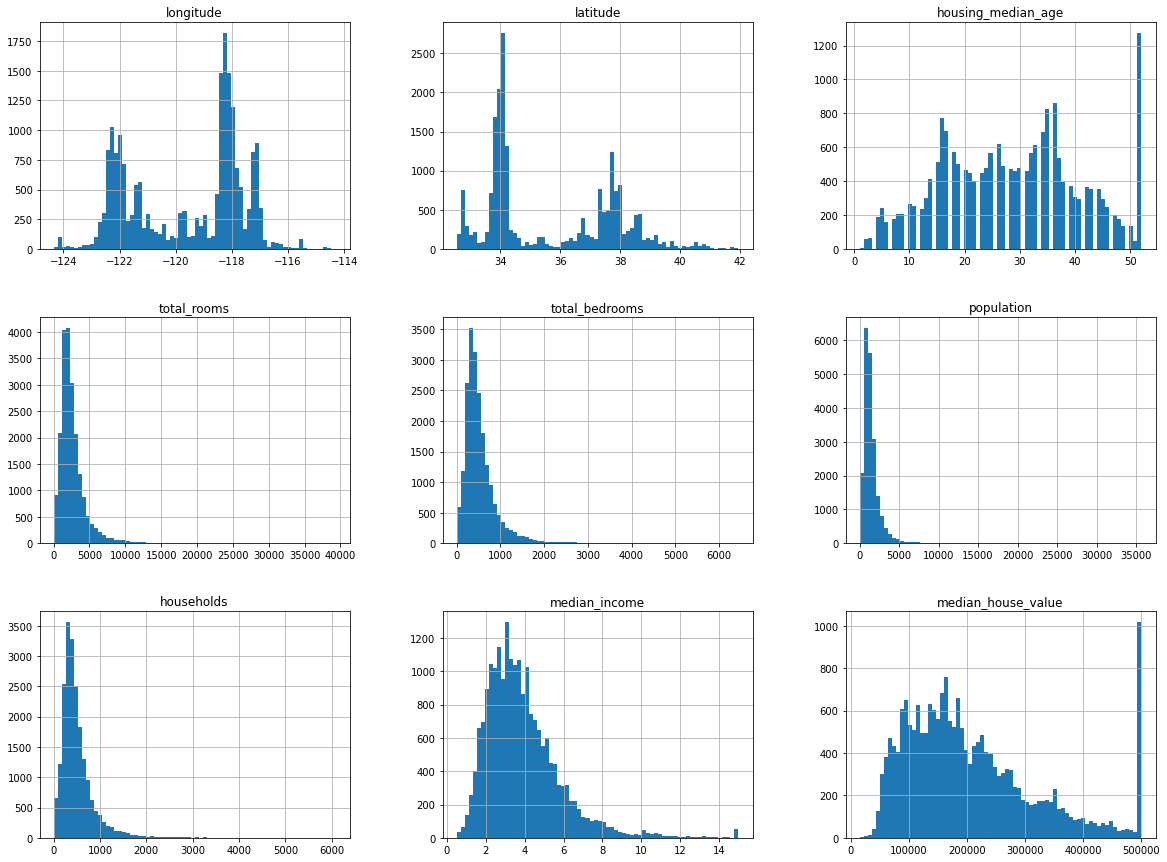

In [72]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=70,figsize=(20,15))
plt.show()

## train_test_split 함수 만들기
----


In [73]:
import numpy as np
def split_train_test(data,test_ratio):
  shuffled_indices=np.random.permutation(len(data))
  test_set_size=int(len(data)*test_ratio)
  test_indices=shuffled_indices[:test_set_size]
  train_indices=shuffled_indices[test_set_size:]
  return data.iloc[train_indices],data.iloc[test_indices]

In [74]:
train_set,test_set=split_train_test(housing,0.2)
print(len(train_set))
print(len(test_set))

16512
4128


In [75]:
housing_with_id=housing.reset_index()
train_set,test_set=split_train_test(housing,0.2)

### 위도와 경도를 이용한 고유값생성

In [76]:
housing_with_id["id"]=housing["longitude"]*1000+housing["latitude"]
train_set,test_set=split_train_test(housing,0.2)

### 사이킷런 스플릿함수

In [77]:
from sklearn.model_selection import train_test_split
train_set,test_set=train_test_split(housing,test_size=0.2,random_state=42)

### pd.cut 함수
  * 범위별로 카테고리형 범주로 바꾼다.

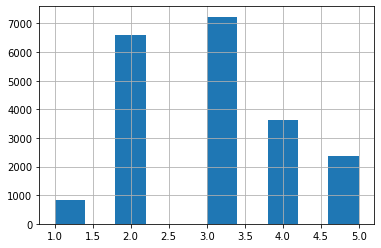

In [78]:
housing["income_cat"]=pd.cut(housing["median_income"],bins=[0,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])
housing["income_cat"].hist()

### 소득 카태고리 기반으로 계층 샘플링
* StratifiedSuffleSplit함수
* 적절한 비율로 나눈다

In [79]:
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index,test_index in split.split(housing,housing["income_cat"]):
  strat_train_set=housing.loc[train_index]
  strat_test_set=housing.loc[test_index]

In [80]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [81]:
housing["income_cat"].value_counts()/len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [82]:
for set_ in (strat_train_set,strat_test_set):
  set_.drop("income_cat",axis=1,inplace=True)
##drop함수에서 inplace를 true로 설정하면 반환하지않고 데이터 자체를 수정한다

# 데이터 이해를 위한 탐색과 시각화

In [83]:
housing=strat_train_set.copy()

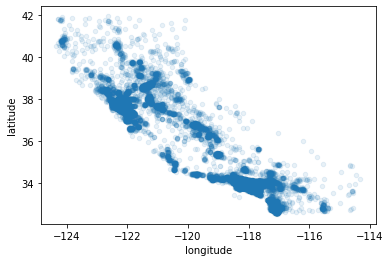

In [84]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.1)
#alpha를 0.1로 둠으로써 투명하게 만들어 시각적으로 밀집지역 확인 용이.

In [85]:
housing["ocp_cat"]=housing["ocean_proximity"].replace(["<1H OCEAN","INLAND","NEAR OCEAN","NEAR BAY","ISLAND"],
                                                      [1,2,3,4,5])

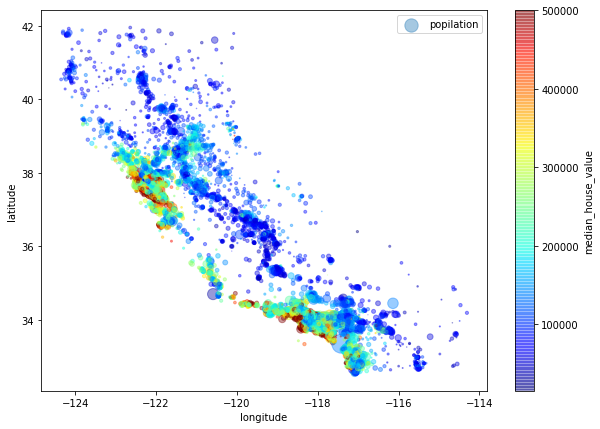

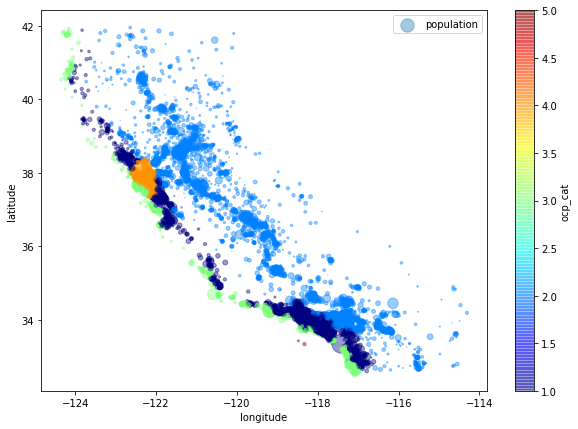

In [86]:
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
             s=housing["population"]/100,label="popilation",figsize=(10,7),
             c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True,
             sharex=False)
housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
             s=housing["population"]/100,label="population",figsize=(10,7),
             c="ocp_cat",cmap=plt.get_cmap("jet"),colorbar=True,
             sharex=False)
plt.legend()
#빨간색이 높은가격 파란색은 낮은 가격
#빨간색일 수록 바다 근접

In [92]:
housing.drop("ocp_cat",axis=1,inplace=True)

### 상관관계 조사
* 상관계수는 선형적인 상관관계만 보여줄 수 있다
* X가 0에 근접하면 Y가 증가하는 경우 딍의 비선형 적 관계는 찾을 수 없다.

In [93]:
corr_matrix=housing.corr()

In [94]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [95]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


* 특성 사이에 산점도를 그려주는 판다스의 scatter_matri

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc4932d5350>,
      dtype=object)

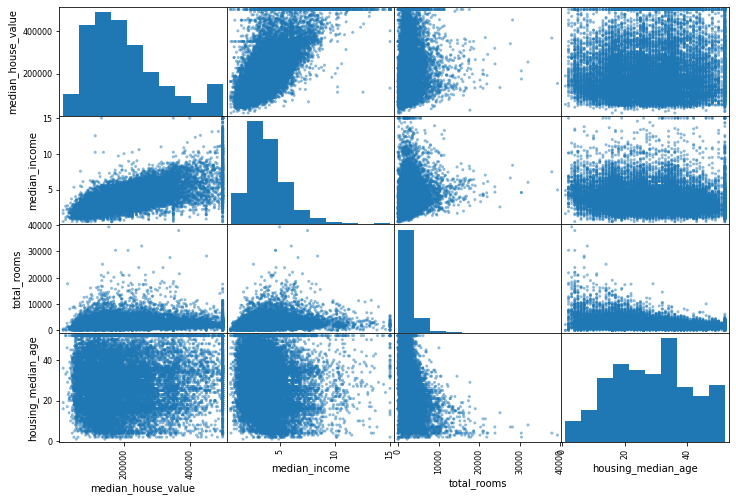

In [99]:
from pandas.plotting import scatter_matrix
attributes=["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(housing[attributes],figsize=(12,8))

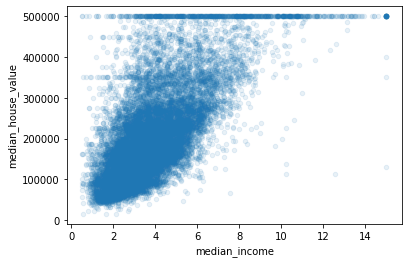

In [100]:
housing.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)

In [103]:
housing["rooms_per_household"]=housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"]=housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [104]:
corr_matrix=housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [105]:
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432,-0.028345,0.095603,-0.000410
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724,0.107621,-0.116884,0.005420
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110,-0.147186,0.136788,0.015031
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097,0.127519,-0.192606,-0.024810
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689,0.000377,0.086960,-0.028370
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920,-0.074692,0.037778,0.076225
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506,-0.083009,0.067162,-0.027416
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160,0.311563,-0.624674,0.021822
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000,0.146285,-0.259984,-0.021985
rooms_per_household,-0.028345,0.107621,-0.147186,0.127519,0.000377,-0.074692,-0.083009,0.311563,0.146285,1.000000,-0.398546,-0.005314


### 머신러닝 알고리즘을 위한 데이터 준비
* 함수를 만들어서 자동화해야한다
  * 어떤 데이터 셋에 관해서도 변환을 손쉽게 반복가능
  * 향후 프로젝트에 사용할 변환 라이브러리를 점진적으로 구축
  * 실제 시스템에서 알고리즘에 새 데이터를 주입하기 전에 변환시키는데 사용
  * 여러가지 데이터 변환을 쉽게 시도하고 어떤 조합이 좋은지 확인 용이

In [112]:
housing=strat_train_set.drop("median_house_value",axis=1)
housing_labels=strat_train_set["median_house_value"].copy()

* null값이 있을경우 세가지 방법 사용
  * 해당 구역을 제거한다
  * 전체 특성을 삭제한다
  * 어떤 값으로 채운다

In [113]:
#housing.dropna(subset=["total_bedrooms"])
#housing.drop("total_bedrooms",axis=1)
median=housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median,inplace=True)

* 사이킷런의 SimpltImputer는 누락된 값을 손쉽게 다루도록 해준다

In [117]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy="median")
housing_num=housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)
print(imputer.statistics_)
print(housing_num.median().values)
X=imputer.transform(housing_num)
housing_tr=pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]
[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


### 텍스트와 범주형 특성 다루기

In [118]:
housing_cat=housing[["ocean_proximity"]]
housing_cat.head(10)


,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [119]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder=OrdinalEncoder()
housing_cat_encoded=ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [121]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 원핫 인코딩

In [122]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder=OneHotEncoder()
housing_cat_1hot=cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [123]:
#메모리 절약을 위해서 장비는 0이 아닌 것의 위치만 기억한다!
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [124]:
#원핫인코딩 된 상태에서도 카테고리명 호출 가능
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## 나만의 변환기
* 자신만의 변환기를 만들어야 할 때가 있다.
* 사이킷런은 상속이나 인터페이스 구현이 아닌 객체의 속성이나 메서드가 객체의 유형을 결정하는 덕타이핑 방식
* 마지막 메서드는 TransformerMixin을 상속하면 자동으로 생성된다. Mixin은 파이썬에서 객체의 기능을 확장하려는 목적으로 만들어진 클래스이다. 
*TransformerMixin은 fit_transform()메서드를 하나 가지고 있으며 상속하는 모든 파이썬 클래스에 이 메서드를 제공한다.
* BaseEstimator를 상속하면 하이퍼 파라미터 튜닝에 필요한 두 메서드(get_params()와 set_params())를 추가로 얻는다.

In [128]:
from sklearn.base import BaseEstimator,TransformerMixin

room_ix,bedrooms_ix,population_ix,households_ix=3,4,5,6

class CombinedAttributesAdder(BaseEstimator,TransformerMixin):
  def __init__(self,add_bedrooms_per_room=True):
    self.add_bedrooms_per_room=add_bedrooms_per_room
  def fit(self,X,y=None):
    return self
  def transform(self,X):
    rooms_per_household=X[:,room_ix]/X[:,households_ix]
    population_per_household=X[:,population_ix]/X[:,households_ix]
    if self.add_bedrooms_per_room:
      add_bedrooms_per_room=X[:,bedrooms_ix]/X[:,room_ix]
      return np.c_[X,rooms_per_household,population_per_household,add_bedrooms_per_room]
    else:
      return np.c_[X,rooms_per_household,population_per_household]
attr_adder=CombinedAttributesAdder(add_bedrooms_per_room=True)
housing_extra_attribs=attr_adder.transform(housing.values)

# 특성 스케일
* min-max스케일링,표준화
* min-max=0~1범위에 오게 한다
* 표준화의 StandardScaler
* 연속된 단계를 나타내는 이름/추정기 목록을 입력받는 Pipeline함수
  * 마지막 단계에는 변환기와 추정기를 모두 사용할 수 있고 그 외에는 모두 변환기여야한다.
  * 이름은 고유값 제외 가능
  * 파이프라인의 fit 메서드를 호출하면 모든 변환기의 fit_transform()메서드 자동 호출하 한 단계의 출력을 다음 단계로 전달, 마지막 단계에서는 fit만 호출

In [130]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline=Pipeline([
                       ('imputer',SimpleImputer(strategy="median")),
                       ('attribs_adder',CombinedAttributesAdder()),
                       ('std_scaler',StandardScaler())
])
housing_num_tr=num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

* 하나의 변환기로 각 열마다 적절한 변환을 적용하여 모든 열을 편하게 처리하는 함수인 ColumnTransformer함수
  * 최종 행렬의 밀집정도를 추정해서 임계값(기본적으로 sparse_threshold=0.3이다.)보다 낮으면 희소행렬 반환

In [136]:
from sklearn.compose import ColumnTransformer
num_attribs=list(housing_num)
cat_attribs=["ocean_proximity"]

full_pipeline=ColumnTransformer([
                                 ("num",num_pipeline,num_attribs),#수치형 변수 변환
                                 ("cat",OneHotEncoder(),cat_attribs)#원핫 인코딩 진행
                                 ])
housing_prepared=full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# 모델 선택과 훈련
* 훈련 테스트 셋 나누고 자동으로 정제하는 파이프라인 정의 후 머신러닝 모델 훈련
---

### 훈련세트에서 훈련하고 평가하기
* 선형 회귀

In [ ]:
from sklearn.linear_model import LinearR